In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.misc
from scipy import ndimage
import matplotlib.pyplot as plt

import pandas as pd
import os 

import time as clock

### Parámetros de Mallado

In [2]:
### RECORREMOS UNA PROFUNDIDAD

dz = 0.01e-6 ## Paso en Profundidad  nm
start_z = 0
stop_z = 0.5e-6

dx = 0.05e-6  ## Paso en Superficie um
start_x = 0e-6
stop_x = 8e-6

### EN UN TIEMPO 
dt = 2.5e-15  ## Time Step fs
start_t = 0
stop_t = 20e-12 ## Finalizamos a ps


x = np.linspace(start_x,stop_x,int(round((stop_x-start_x)/dx)))
z = np.linspace(start_z,stop_z,int(round((stop_z-start_z)/dz)))
t = np.linspace(start_t,stop_t,int(round((stop_t-start_t)/dt)))

X,Z= np.meshgrid(x,z)

### Parámetros Generales Red y Láser

In [3]:
# ------------- Red Electrones -----------------
Ce_aux = 134.5 # J / (m^3 K^2)
ke = 235  # J /(m K s)
g = 5.69e17 # J /(m K^3 s)

#  ----------------------------------------------

# ------------- Red Lattice -----------------
Ci = 2.42e6  # J / (m^3 K)
ki = ke/99 # J (m K^3 s) 
#  -------------------------------------------


# ------------- Parámetros Láser -----------------
R = 0.88 # Reflectancia A.U.
delta = 20e-9 # Optical Penetration (nm)
ball_len = 100e-9 # Ballistic Length (nm)
 
tp = 100e-15 # FWHM fs
w0 = 12.4e-6 # Waist um
wavelength = 1.032e-6 # Wavelength (um)
#  ------------------------------------------------------

# ------------- Parámetros Varios -----------------
ys = 3e-6 ## Perfil de Apertura del Láser (um)
T0 = 300 # K Temperatura Ambiente (K)
x0 = 0 # Posición central del Spot en x
n = 1 ## Refractive Index
Zr = n*np.pi*w0**2/wavelength
w = w0*(1+Z**2/Zr**2)**1/2


Tc = 5370 # Temperatura Crítica (K)
f = 2e4 # J/m^2

In [4]:
S = (1-R)/(delta + ball_len) * f * w0**2/w**2 * np.exp(
    -(Z)/(delta+ball_len) - (2*(X-x0)**2/w**2))

### Valores para iniciar

In [5]:
Te = np.ones_like(X)*T0
Ti = np.ones_like(X)*T0

In [6]:
cte_e = dt/Ce_aux
cte_i = dt/Ci

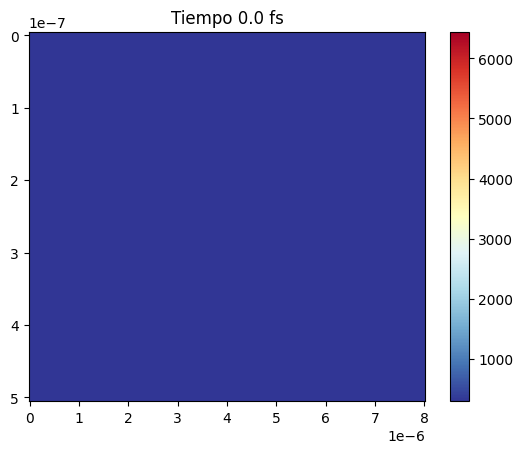

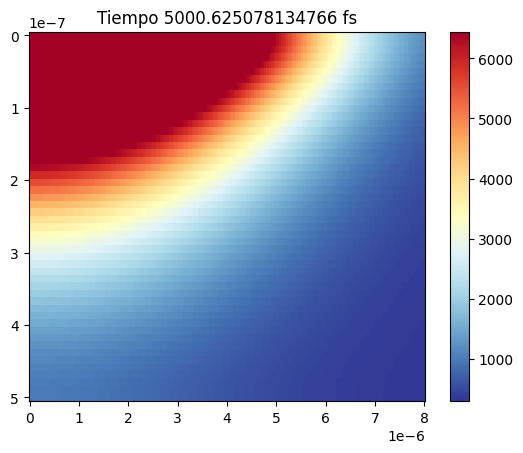

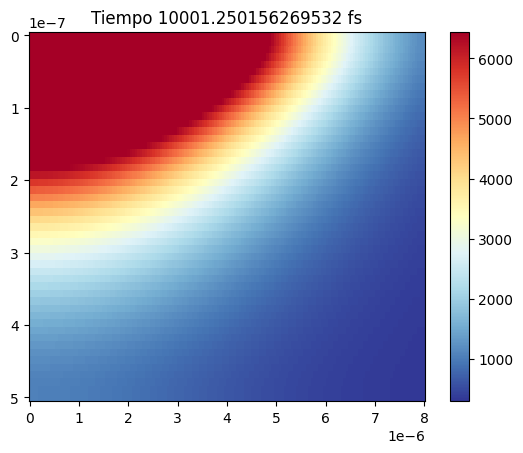

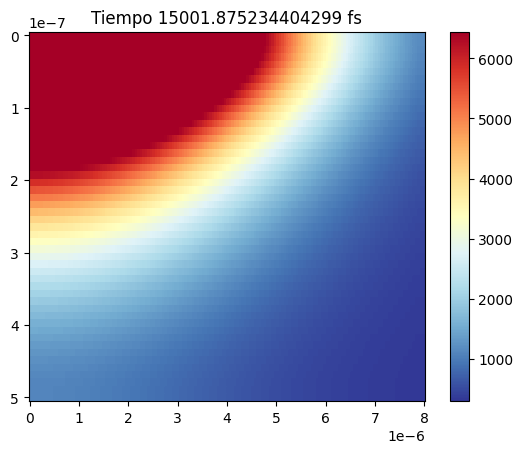

In [7]:
Tenew = np.ones_like(Te)*T0
Tinew = np.ones_like(Ti)*T0
Te_profile_quick = np.zeros_like(t)
Ti_profile_quick = np.zeros_like(t)

start_quick =  clock.time()
for k,time in enumerate(t):
    
    
    T = 1/tp * np.sqrt(4 * np.log(2)/np.pi) * np.exp(
    -4*np.log(2) * ((time - 2*tp)/tp)**2) 
    
    
    Q = S*T
    
    ## Valores Electrónicos
    A = Te[2:,1:-1]
    B = Te[:-2,1:-1]
    C = Te[1:-1,2:]
    D = Te[1:-1,:-2]
    E = Te[1:-1,1:-1]
    ## Valores Lattice
    G = Ti[2:,1:-1]
    H = Ti[:-2,1:-1]
    I = Ti[1:-1,2:]
    J = Ti[1:-1,:-2]
    K = Ti[1:-1,1:-1]
    Q_reduced = Q[1:-1,1:-1]
    
    Tenew[1:-1,1:-1] = E + cte_e/E * (
    ke/dz**2 * (A+B-2*E) + ke/dx**2 * (C+D-2*E) - g*(E-K) + Q_reduced)
    
    Tinew[1:-1,1:-1] = K + cte_i * (
        ki/dz**2 * (G+H-2*K) + ki/dx**2 * (I+J-2*K) + g*(E-K))
    
    ### CONDICIONES DE CONTORNO
    Tenew[0,:], Tenew[-1,:], Tenew[:,0], Tenew[:,-1] = Tenew[1,:], Tenew[-2,:], Tenew[:,1], Tenew[:,-2]
    Tinew[0,:], Tinew[-1,:], Tinew[:,0], Tinew[:,-1] = Tinew[1,:], Tinew[-2,:], Tinew[:,1], Tinew[:,-2]
    Te = Tenew
    Ti = Tinew
        
    if k % 2000 == 0 :
        plt.title(f"Tiempo {time*1e15} fs")
        plt.pcolor(x,z,Tinew,cmap='RdYlBu_r',vmin = 300, vmax = Tc*1.2)
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.show()

    Te_profile_quick[k] = Te[0,0]
    Ti_profile_quick[k] = Ti[0,0]
    
end_quick = clock.time()

In [8]:
print(f"TIEMPO DEL LOOP:{end_quick-start_quick:.2f} s")
    

TIEMPO DEL LOOP:1.41 s


In [9]:
### LASER POWER PARA PRIMER PULSO
T = 1/tp * np.sqrt(4 * np.log(2)/np.pi) * np.exp(
-4*np.log(2) * ((t - 2*tp)/tp)**2)
S = (1-R)/(delta + ball_len) * f * w0**2/w**2 * np.exp(
    -(Z)/(delta+ball_len) - (2*(X-x0)**2/w**2))

In [10]:
Te = np.ones_like(X[:,:])*300
Ti = np.ones_like(X[:,:])*300
Tenew,Tinew = np.zeros_like(Te), np.zeros_like(Ti)

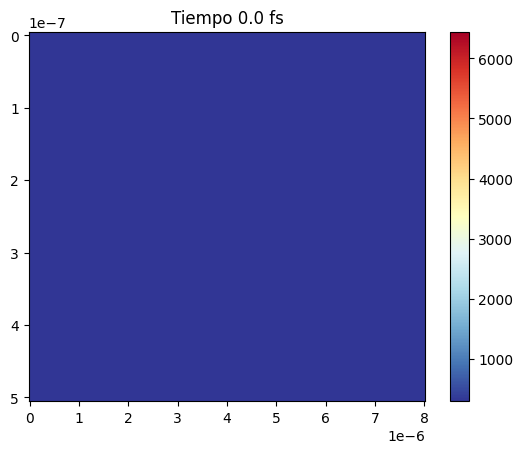

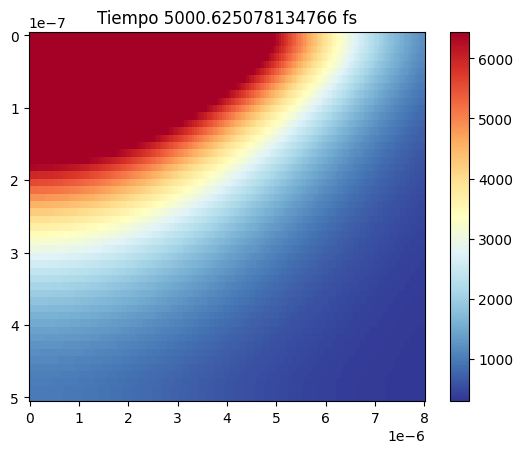

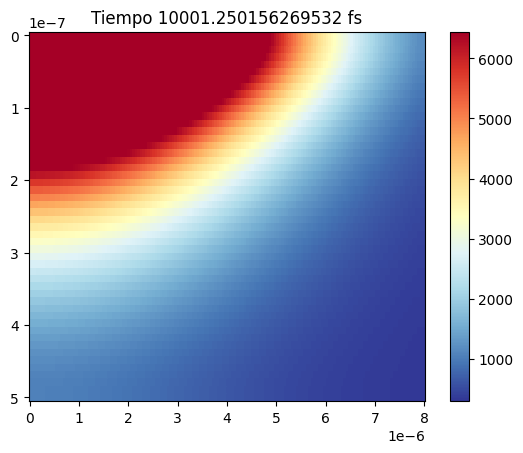

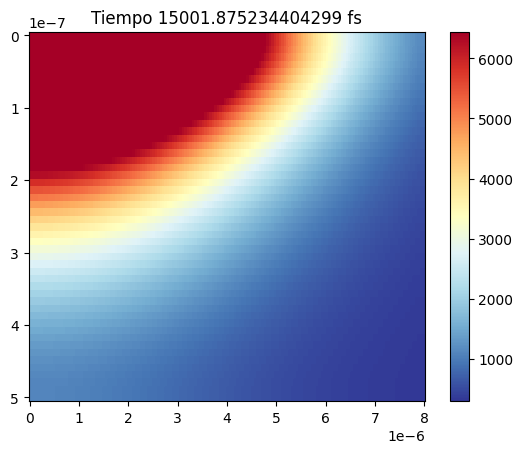

In [13]:
Te_profile = np.zeros_like(t)
Ti_profile = np.zeros_like(t)


start_time = clock.time()
for n in range(0,len(t)-1):
    for i in range(1,len(z)-1):
        for k in range(1,len(x)-1):
            Tenew[i,k] = Te[i,k] + cte_e/Te[i,k]*(
                ke*((Te[i+1,k] - 2 * Te[i,k] + Te[i-1,k])/dz/dz + (Te[i,k+1] -2*Te[i,k] + Te[i,k-1])/dx/dx)) - (
                cte_e/Te[i,k]*g*(Te[i,k]-Ti[i,k])) + cte_e/Te[i,k]*S[i,k]*T[n]

            Tinew[i,k] = Ti[i,k] + dt*ki/Ci * (
                (Ti[i+1,k]-2*Ti[i,k]+Ti[i-1,k])/dz/dz + (Ti[i,k+1]-2*Ti[i,k]+Ti[i,k-1])/dx/dx) + g*dt/Ci * (Te[i,k] - Ti[i,k])

    ### CONDICIONES DE CONTORNO
    Tenew[0,:], Tenew[-1,:], Tenew[:,0], Tenew[:,-1] = Tenew[1,:], Tenew[-2,:], Tenew[:,1], Tenew[:,-2]
    Tinew[0,:], Tinew[-1,:], Tinew[:,0], Tinew[:,-1] = Tinew[1,:], Tinew[-2,:], Tinew[:,1], Tinew[:,-2]
    Te = Tenew
    Ti = Tinew

    if n % 2000 == 0 :
        plt.title(f"Tiempo {t[n]*1e15} fs")
        plt.pcolor(x,z,Tinew,cmap='RdYlBu_r',vmin = 300, vmax = Tc*1.2)
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.show()
    
    Te_profile[n] = Te[0,0]
    Ti_profile[n] = Ti[0,0]

finish_time = clock.time()

In [14]:
print(f"TIEMPO DEL LOOP:{finish_time-start_time:.2f} s")

TIEMPO DEL LOOP:204.78 s


In [1]:
plt.plot(Ti_profile[:-1],c="r",ls="dotted")
plt.plot(Te_profile[:-1],c="r")
plt.plot(Ti_profile_quick,c="g",ls="dotted")
plt.plot(Te_profile_quick,c="g")

NameError: name 'plt' is not defined